In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1434 entries, 0 to 1433
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1434 non-null   object 
 1   Price     1434 non-null   float64
 2   Open      1434 non-null   float64
 3   High      1434 non-null   float64
 4   Low       1434 non-null   float64
 5   Vol       1434 non-null   int64  
 6   Change %  1434 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 78.6+ KB


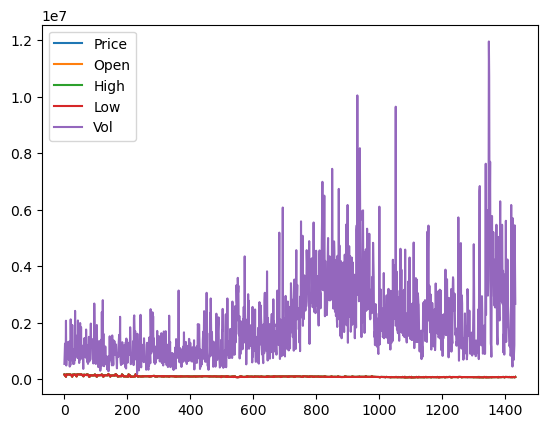

In [50]:
data = pd.read_excel('VNM Historical Data Refine.xlsx')
data['Date'] = pd.to_datetime(data['Date']).dt.date
data.plot()
data.info()

In [51]:
data.head()

,Date,Price,Open,High,Low,Vol,Change %
0,2018-01-02,165933.0,166750.0,168876.0,164298.0,541520,-0.25%
1,2018-01-03,160211.0,160211.0,162663.0,160211.0,879470,0.00%
2,2018-01-06,137487.0,135689.0,138305.0,135280.0,1260000,2.44%
3,2018-01-08,137604.0,138511.0,138676.0,137357.0,821720,-0.77%
4,2018-01-10,105803.0,106191.0,106346.0,105570.0,617780,-0.73%


In [52]:
# data = data.set_index(pd.DatetimeIndex(data['Date']))
data = data['Price']
data = data.dropna()
data = data.reset_index(drop=True) # Reset the index

In [53]:
data.head()


0    165933.0
1    160211.0
2    137487.0
3    137604.0
4    105803.0
Name: Price, dtype: float64

Normalizing event log files

<Axes: >

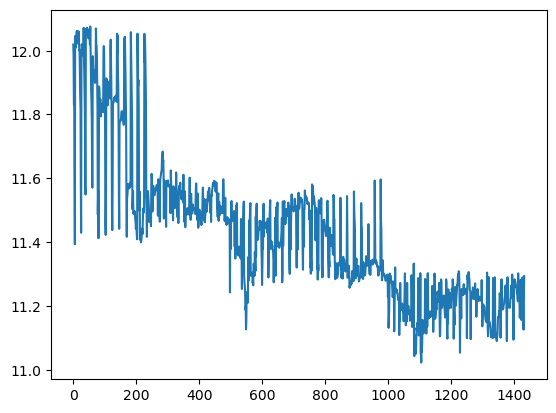

In [55]:
df = np.log(data)
df.plot()

In [56]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

<Axes: >

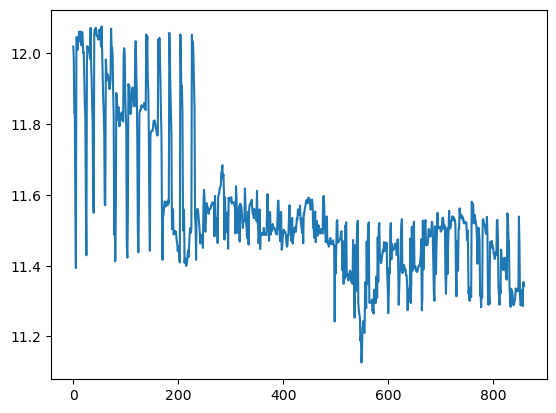

In [57]:
train_data.plot()

testing the stationary of data using acf
Definition: ACF(Autocorrelation function): correlation of the time series with its lags
            PACF(Partial Autocorrelation function): partial correlation of the time series after removing order lags between lags

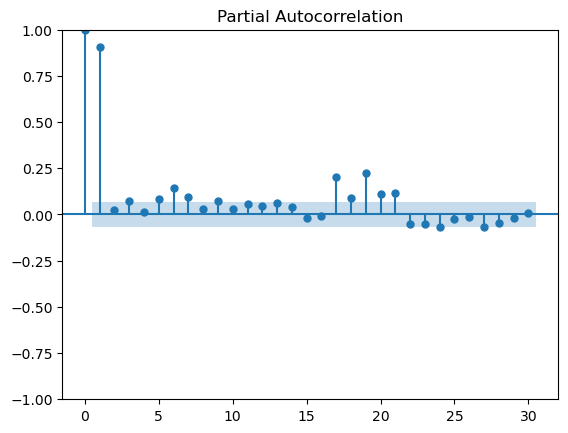

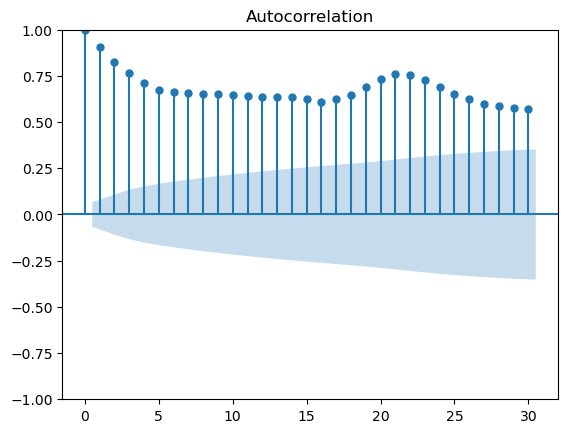

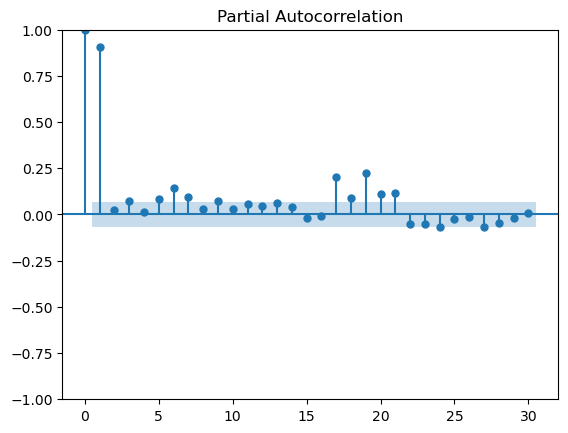

In [58]:
sm.graphics.tsa.plot_acf(train_data)
sm.graphics.tsa.plot_pacf(train_data)

Statistical ADS test
Definition: Augmented Dickey Fuller test:
    Null hypothesis: there is a unit root (non_stationary)

In [59]:
adfuller(train_data)

(-2.1285930976354623,
 0.2331736625224003,
 20,
 839,
 {'1%': -3.438168140637663,
  '5%': -2.864991017121922,
  '10%': -2.5686076019468094},
 -2040.5326779205152)

test-statistic: -32.43416092918354
p-value:0.2331736625224003

Since the p-value is not less than .05, we fail to reject the null hypothesis.

This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

<Axes: >

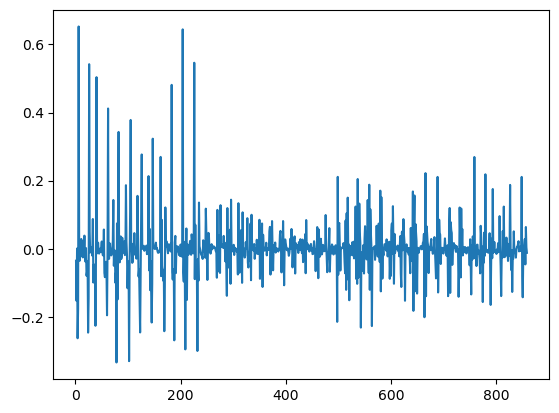

In [60]:
train_data_diff =  train_data.diff().dropna()
train_data_diff.plot()

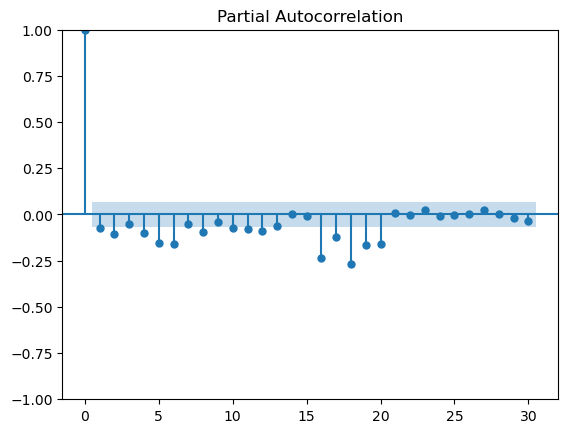

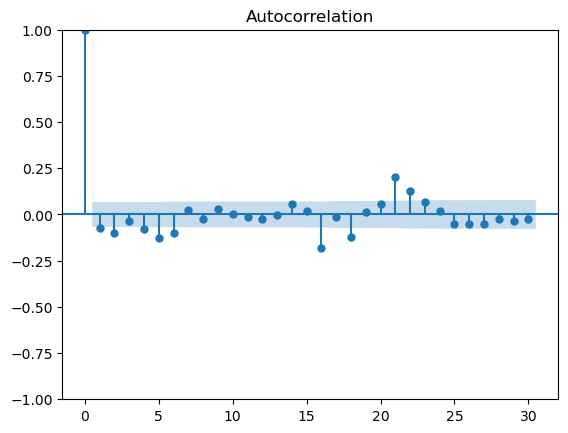

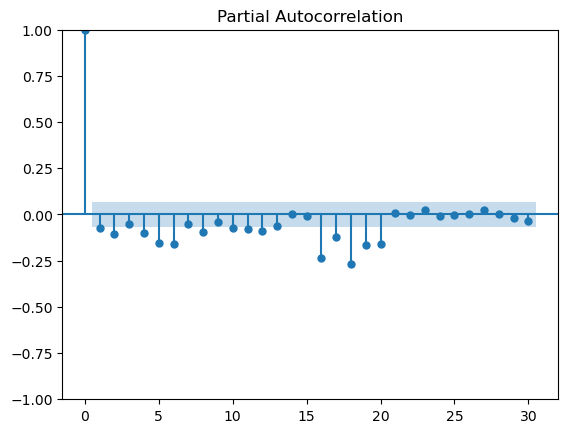

In [61]:
sm.graphics.tsa.plot_acf(train_data_diff)
sm.graphics.tsa.plot_pacf(train_data_diff)

In [62]:
adfuller(train_data_diff)

(-16.88315136220155,
 1.0590660206554875e-29,
 19,
 839,
 {'1%': -3.438168140637663,
  '5%': -2.864991017121922,
  '10%': -2.5686076019468094},
 -2035.031264348505)

test-statistic: -12.106714517476552
p-value:1.0590660206554875e-29

Since the p-value is less than .05, we reject the null hypothesis.

This means the time series is stationary. In other words, it does not have some time-dependent structure and have constant variance over time.

Rule: if the PACF plot has a significant spike at lag p, but not beyond, the ACF plot decay more gradually. This may suggest an ARIMA(p,d,0) model
if ACF plot has a significant spike at lag p, but not beyond; the PACF plot decay more gradually. This may suggest an ARIMA(0,d,q) model

Since we have a spike at ACF plot and the plots at DACF got gradually decrease so we assuming that the ARIMA model is (0,d,p)

so our current ARIMA model is (0,1,p)
we shall start p at 2

In [101]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data,order = (15,1,9))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\hthan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hthan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  860
Model:                ARIMA(15, 1, 9)   Log Likelihood                 979.277
Date:                Sun, 12 Nov 2023   AIC                          -1908.554
Time:                        12:12:21   BIC                          -1789.659
Sample:                             0   HQIC                         -1863.034
                                - 860                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3205      0.649     -0.494      0.622      -1.593       0.952
ar.L2         -0.2175      0.679     -0.320      0.749      -1.548       1.113
ar.L3         -0.1499      0.424     -0.354      0.7

C:\Users\hthan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


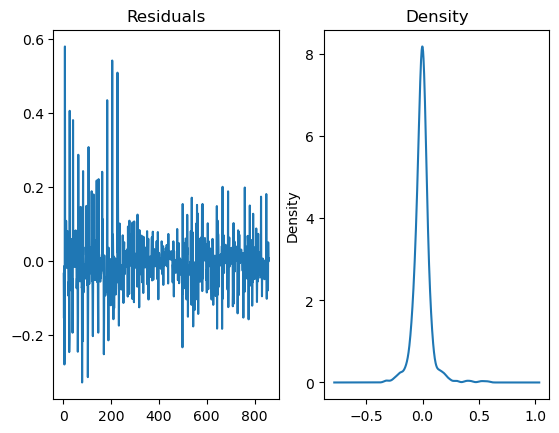

In [64]:
residuals = model_fit.resid[1:]
fig,ax = plt.subplots(1,2)
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

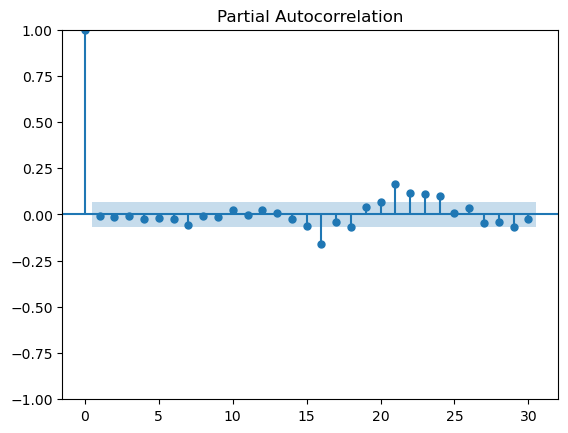

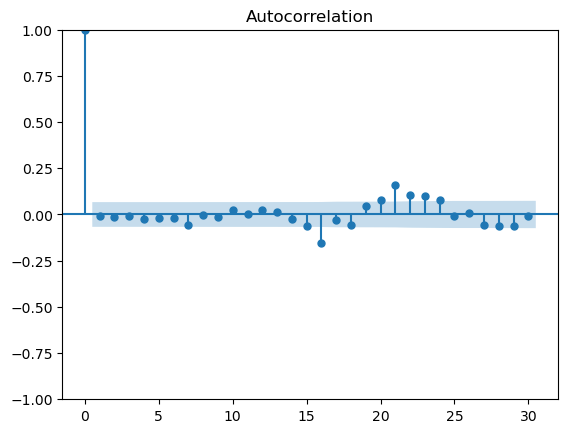

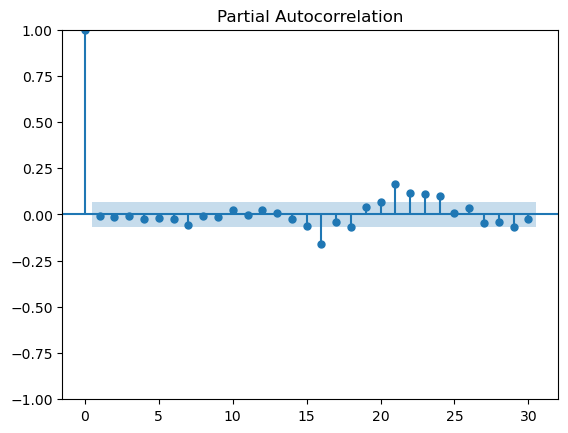

In [65]:
sm.graphics.tsa.plot_acf(residuals)
sm.graphics.tsa.plot_pacf(residuals)

In [66]:
# df2 = df.reset_index(drop=True)
# df2.plot()
forecast_test = model_fit.forecast(len(test_data))
forecast_test.index = test_data.index
forecast_test.head()
# df2['forecast_manual'] = [None]*len(test_data) + list(forecast_test)
# df2 = pd.Series(forecast_test,index = test_data.index)
# df2.head()
# df2[0] = 
# print(df2[0].dtypes)
# print(df2.dtypes)


860    11.340099
861    11.338777
862    11.352623
863    11.362120
864    11.381091
Name: predicted_mean, dtype: float64

In [67]:
test_data.head()

860    11.333375
861    11.345390
862    11.328970
863    11.328970
864    11.322325
Name: Price, dtype: float64

<Axes: >

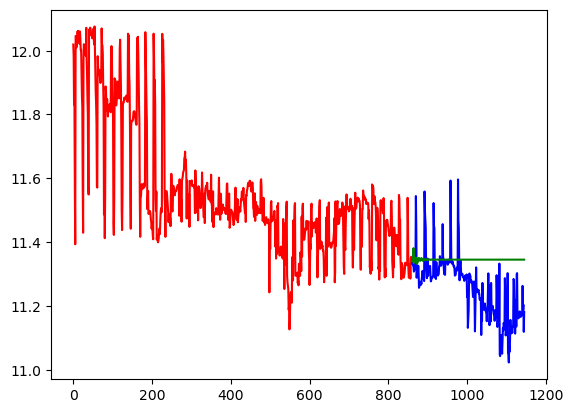

In [68]:
train_data.plot(color = 'red', label = "data")
test_data.plot(color = 'blue', label = "Real")
forecast_test.plot(color = "green", label = "predicted")

Quá trình training bằng auto_arima

In [69]:
!pip install pmdarima

In [100]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1893.404, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1784.574, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1787.110, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1788.332, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1786.501, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1896.749, Time=1.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1892.315, Time=1.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1794.519, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1896.448, Time=2.95 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1794.861, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1893.296, Time=1.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1893.704, Time=0.19 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 10.306 seconds


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [99]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train, order=(2,1,1))
fitted_model = model1.fit()
print(fitted_model.summary())

C:\Users\hthan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hthan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  860
Model:                ARIMA(15, 1, 9)   Log Likelihood                 979.277
Date:                Sun, 12 Nov 2023   AIC                          -1908.554
Time:                        12:11:33   BIC                          -1789.659
Sample:                             0   HQIC                         -1863.034
                                - 860                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3205      0.649     -0.494      0.622      -1.593       0.952
ar.L2         -0.2175      0.679     -0.320      0.749      -1.548       1.113
ar.L3         -0.1499      0.424     -0.354      0.7

C:\Users\hthan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [98]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

In [95]:
# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [96]:
from datetime import datetime, timedelta

In [97]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[11.34290219 11.34429687 11.3450584  11.34528385 11.34515648 11.34480731
 11.3443201  11.34374715 11.34312098 11.34246179 11.34178209 11.34108968
 11.34038936 11.33968415 11.3389759  11.33826576 11.33755444 11.3368424
 11.33612991 11.33541714 11.33470419 11.33399114 11.33327802 11.33256486
 11.33185167 11.33113847 11.33042525 11.32971203 11.32899881 11.32828558]


In [93]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mae = np.mean(np.abs(y_val - y_pred_val))
test_mae = np.mean(np.abs(y_test - y_pred))
print(f'Validation RMSE: {valid_rmse:.2f}')
# print(f'Testing RMSE: {test_rmse:.5f}')
print(f'Validation MAPE: {valid_mape:.2f}')
# print('Testing MAPE:', test_mape)
print(f'Validation MAE: {valid_mae:.2f}')
# print('Testing MAE:', test_mae)

Validation RMSE: 0.09
Validation MAPE: 0.62
Validation MAE: 0.07


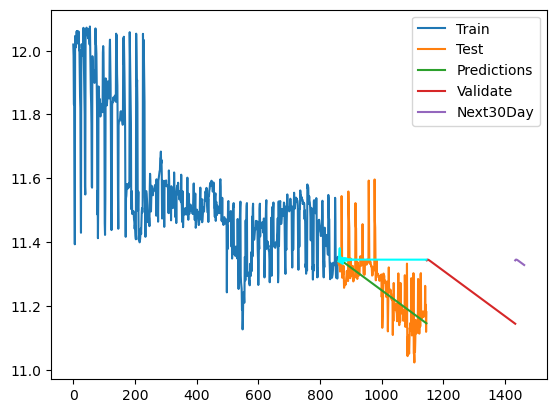

In [102]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
forecast_test.plot(color = "cyan", label = "predicted")
plt.show()